In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './CIFAR10_Syn_Coreset'
ipc = 500

### CIFAR10 Coreset

In [3]:
class CIFAR10_Coreset(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv(f'./coreset_index_cifar10/ipc{ipc}_idx.csv')
index_file

,image_path,label
0,./CIFAR10_Syn_Coreset/ipc500/airplane/0028d579...,0
1,./CIFAR10_Syn_Coreset/ipc500/airplane/00552627...,0
2,./CIFAR10_Syn_Coreset/ipc500/airplane/01cd31cc...,0
3,./CIFAR10_Syn_Coreset/ipc500/airplane/01dd4085...,0
4,./CIFAR10_Syn_Coreset/ipc500/airplane/02647336...,0
...,...,...
4995,./CIFAR10_Syn_Coreset/ipc500/truck/fd91675f-87...,9
4996,./CIFAR10_Syn_Coreset/ipc500/truck/fea8d090-60...,9
4997,./CIFAR10_Syn_Coreset/ipc500/truck/ff00e89c-3d...,9
4998,./CIFAR10_Syn_Coreset/ipc500/truck/ff128b20-69...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_coreset_train = CIFAR10_Coreset(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
batch_size = 32 
train_data_loader, test_data_loader = get_data_loaders(cifar10_coreset_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
model_path = f'./model_weight/ipc{ipc}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 157/157 [00:04<00:00, 34.80it/s, loss=0.3]  


epoch: 1 done, loss: 0.022121837362647057
Acc: 0.4144
[0.001]


Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 40.20it/s, loss=0.276] 


epoch: 2 done, loss: 0.0055152736604213715
Acc: 0.4414
[0.001]


Epoch 3: 100%|██████████| 157/157 [00:04<00:00, 39.23it/s, loss=0.00908]


epoch: 3 done, loss: 0.0029802212957292795
Acc: 0.4511
[0.001]


Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 45.33it/s, loss=0.0212]


epoch: 4 done, loss: 0.0019376109121367335
Acc: 0.4603
[0.001]


Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 45.26it/s, loss=0.00643]


epoch: 5 done, loss: 0.0011850970331579447
Acc: 0.4684
[0.0001]


Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 44.68it/s, loss=0.00615]


epoch: 6 done, loss: 0.0007188430754467845
Acc: 0.4859
[0.0001]


Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 46.11it/s, loss=0.0672] 


epoch: 7 done, loss: 0.0005297716706991196
Acc: 0.4848
[0.0001]


Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 42.57it/s, loss=0.0172] 


epoch: 8 done, loss: 0.00047335674753412604
Acc: 0.4845
[0.0001]


Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 42.41it/s, loss=0.00333]


epoch: 9 done, loss: 0.0004411297559272498
Acc: 0.4807
[1e-05]


Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 42.33it/s, loss=0.00333]


epoch: 10 done, loss: 0.0004104405816178769
Acc: 0.4836
[1e-05]


Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 42.89it/s, loss=0.00177]


epoch: 11 done, loss: 0.0003948611847590655
Acc: 0.4843
[1e-05]


Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 43.18it/s, loss=0.00107]


epoch: 12 done, loss: 0.00038577025406993926
Acc: 0.4849
[1e-05]


Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 41.52it/s, loss=0.00891]


epoch: 13 done, loss: 0.0003861413279082626
Acc: 0.4854
[1.0000000000000002e-06]


Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 41.52it/s, loss=0.00147]


epoch: 14 done, loss: 0.0003898233699146658
Acc: 0.4853
[1.0000000000000002e-06]


Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 42.18it/s, loss=0.00362]


epoch: 15 done, loss: 0.00037055430584587157
Acc: 0.4851
[1.0000000000000002e-06]


Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 42.58it/s, loss=0.00513]


epoch: 16 done, loss: 0.00037442726898007095
Acc: 0.485
[1.0000000000000002e-06]


Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 42.85it/s, loss=0.00968]


epoch: 17 done, loss: 0.0003625619283411652
Acc: 0.4854
[1.0000000000000002e-06]


Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 42.19it/s, loss=0.0169] 


epoch: 18 done, loss: 0.0003693811595439911
Acc: 0.4851
[1.0000000000000002e-06]


Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 42.30it/s, loss=0.00725]


epoch: 19 done, loss: 0.0003869843203574419
Acc: 0.4852
[1.0000000000000002e-06]


Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 41.41it/s, loss=0.00719]


epoch: 20 done, loss: 0.00037485238863155246
Acc: 0.4853
[1.0000000000000002e-06]


Epoch 21: 100%|██████████| 157/157 [00:03<00:00, 41.03it/s, loss=0.00083]


epoch: 21 done, loss: 0.00036855353391729295
Acc: 0.4851
[1.0000000000000002e-06]


Epoch 22: 100%|██████████| 157/157 [00:03<00:00, 41.71it/s, loss=0.00683]


epoch: 22 done, loss: 0.00036697598989121616
Acc: 0.4855
[1.0000000000000002e-06]


Epoch 23: 100%|██████████| 157/157 [00:03<00:00, 41.34it/s, loss=0.00871]


epoch: 23 done, loss: 0.00037570390850305557
Acc: 0.4854
[1.0000000000000002e-06]


Epoch 24: 100%|██████████| 157/157 [00:03<00:00, 41.61it/s, loss=0.000915]


epoch: 24 done, loss: 0.0003788963658735156
Acc: 0.4857
[1.0000000000000002e-06]


Epoch 25: 100%|██████████| 157/157 [00:03<00:00, 42.90it/s, loss=0.00425]


epoch: 25 done, loss: 0.00036917394027113914
Acc: 0.4855
[1.0000000000000002e-06]


Epoch 26: 100%|██████████| 157/157 [00:03<00:00, 42.08it/s, loss=0.00844]


epoch: 26 done, loss: 0.0003684435214381665
Acc: 0.4855
[1.0000000000000002e-06]


Epoch 27: 100%|██████████| 157/157 [00:03<00:00, 41.24it/s, loss=0.000605]


epoch: 27 done, loss: 0.0003672046586871147
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 28: 100%|██████████| 157/157 [00:03<00:00, 41.82it/s, loss=0.00991]


epoch: 28 done, loss: 0.0003733342746272683
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 29: 100%|██████████| 157/157 [00:03<00:00, 43.10it/s, loss=0.0281] 


epoch: 29 done, loss: 0.00035844178637489676
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 30: 100%|██████████| 157/157 [00:03<00:00, 41.96it/s, loss=0.00149]


epoch: 30 done, loss: 0.0003721871180459857
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 31: 100%|██████████| 157/157 [00:03<00:00, 42.17it/s, loss=0.00372]


epoch: 31 done, loss: 0.00036999097210355103
Acc: 0.4861
[1.0000000000000002e-06]


Epoch 32: 100%|██████████| 157/157 [00:03<00:00, 42.03it/s, loss=0.0139] 


epoch: 32 done, loss: 0.000357650249497965
Acc: 0.486
[1.0000000000000002e-06]


Epoch 33: 100%|██████████| 157/157 [00:03<00:00, 41.73it/s, loss=0.0168] 


epoch: 33 done, loss: 0.000371019501471892
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 34: 100%|██████████| 157/157 [00:03<00:00, 42.79it/s, loss=0.0044] 


epoch: 34 done, loss: 0.0003579367185011506
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 35: 100%|██████████| 157/157 [00:03<00:00, 43.05it/s, loss=0.0156] 


epoch: 35 done, loss: 0.00036856424412690103
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 36: 100%|██████████| 157/157 [00:03<00:00, 40.98it/s, loss=0.00142]


epoch: 36 done, loss: 0.00036688035470433533
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 37: 100%|██████████| 157/157 [00:03<00:00, 41.18it/s, loss=0.0155]  


epoch: 37 done, loss: 0.00036268934491090477
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 38: 100%|██████████| 157/157 [00:03<00:00, 41.97it/s, loss=0.00523]


epoch: 38 done, loss: 0.0003627495316322893
Acc: 0.486
[1.0000000000000002e-06]


Epoch 39: 100%|██████████| 157/157 [00:03<00:00, 41.69it/s, loss=0.0013] 


epoch: 39 done, loss: 0.000361506303306669
Acc: 0.486
[1.0000000000000002e-06]


Epoch 40: 100%|██████████| 157/157 [00:03<00:00, 42.12it/s, loss=0.00801] 


epoch: 40 done, loss: 0.00036021872074343264
Acc: 0.4857
[1.0000000000000002e-06]


Epoch 41: 100%|██████████| 157/157 [00:03<00:00, 41.91it/s, loss=0.0125] 


epoch: 41 done, loss: 0.000356263539288193
Acc: 0.4857
[1.0000000000000002e-06]


Epoch 42: 100%|██████████| 157/157 [00:03<00:00, 43.35it/s, loss=0.00281]


epoch: 42 done, loss: 0.0003595072776079178
Acc: 0.4863
[1.0000000000000002e-06]


Epoch 43: 100%|██████████| 157/157 [00:03<00:00, 41.37it/s, loss=0.023]  


epoch: 43 done, loss: 0.00037235720083117485
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 44: 100%|██████████| 157/157 [00:03<00:00, 40.99it/s, loss=0.0046] 


epoch: 44 done, loss: 0.00034584521199576557
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 45: 100%|██████████| 157/157 [00:03<00:00, 42.35it/s, loss=0.00397]


epoch: 45 done, loss: 0.0003508716472424567
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 46: 100%|██████████| 157/157 [00:03<00:00, 42.15it/s, loss=0.0103] 


epoch: 46 done, loss: 0.00035013866727240384
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 47: 100%|██████████| 157/157 [00:03<00:00, 42.41it/s, loss=0.0281] 


epoch: 47 done, loss: 0.0003666147531475872
Acc: 0.486
[1.0000000000000002e-06]


Epoch 48: 100%|██████████| 157/157 [00:03<00:00, 41.89it/s, loss=0.00194]


epoch: 48 done, loss: 0.00036893205833621323
Acc: 0.486
[1.0000000000000002e-06]


Epoch 49: 100%|██████████| 157/157 [00:03<00:00, 41.50it/s, loss=0.00488]


epoch: 49 done, loss: 0.0003444414178375155
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 50: 100%|██████████| 157/157 [00:03<00:00, 42.54it/s, loss=0.0147] 


epoch: 50 done, loss: 0.0003430759534239769
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 51: 100%|██████████| 157/157 [00:03<00:00, 42.31it/s, loss=0.0444] 


epoch: 51 done, loss: 0.0003557672316674143
Acc: 0.4857
[1.0000000000000002e-06]


Epoch 52: 100%|██████████| 157/157 [00:03<00:00, 40.94it/s, loss=0.00216]


epoch: 52 done, loss: 0.00036361158709041774
Acc: 0.4861
[1.0000000000000002e-06]


Epoch 53: 100%|██████████| 157/157 [00:03<00:00, 41.79it/s, loss=0.00205]


epoch: 53 done, loss: 0.0003642431111074984
Acc: 0.486
[1.0000000000000002e-06]


Epoch 54: 100%|██████████| 157/157 [00:03<00:00, 42.09it/s, loss=0.000691]


epoch: 54 done, loss: 0.0003435910912230611
Acc: 0.486
[1.0000000000000002e-06]


Epoch 55: 100%|██████████| 157/157 [00:03<00:00, 44.25it/s, loss=0.00452]


epoch: 55 done, loss: 0.00035362568451091647
Acc: 0.486
[1.0000000000000002e-06]


Epoch 56: 100%|██████████| 157/157 [00:03<00:00, 46.92it/s, loss=0.00221]


epoch: 56 done, loss: 0.0003588517429307103
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 57: 100%|██████████| 157/157 [00:03<00:00, 45.81it/s, loss=0.00108]


epoch: 57 done, loss: 0.0003566670638974756
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 58: 100%|██████████| 157/157 [00:03<00:00, 45.51it/s, loss=0.00415]


epoch: 58 done, loss: 0.0003426540060900152
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 59: 100%|██████████| 157/157 [00:03<00:00, 46.51it/s, loss=0.00107]


epoch: 59 done, loss: 0.0003480006707832217
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 60: 100%|██████████| 157/157 [00:03<00:00, 46.78it/s, loss=0.00153]


epoch: 60 done, loss: 0.0003408907214179635
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 61: 100%|██████████| 157/157 [00:03<00:00, 45.80it/s, loss=0.0128] 


epoch: 61 done, loss: 0.0003552188281901181
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 62: 100%|██████████| 157/157 [00:03<00:00, 46.90it/s, loss=0.00942]


epoch: 62 done, loss: 0.00036240581539459527
Acc: 0.4857
[1.0000000000000002e-06]


Epoch 63: 100%|██████████| 157/157 [00:03<00:00, 47.55it/s, loss=0.00252]


epoch: 63 done, loss: 0.0003431421937420964
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 64: 100%|██████████| 157/157 [00:03<00:00, 45.05it/s, loss=0.0103] 


epoch: 64 done, loss: 0.00033868980244733393
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 65: 100%|██████████| 157/157 [00:03<00:00, 46.82it/s, loss=0.0011] 


epoch: 65 done, loss: 0.00035788194509223104
Acc: 0.486
[1.0000000000000002e-06]


Epoch 66: 100%|██████████| 157/157 [00:03<00:00, 46.74it/s, loss=0.0142] 


epoch: 66 done, loss: 0.0003674806794151664
Acc: 0.486
[1.0000000000000002e-06]


Epoch 67: 100%|██████████| 157/157 [00:03<00:00, 44.41it/s, loss=0.0194] 


epoch: 67 done, loss: 0.0003393889346625656
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 68: 100%|██████████| 157/157 [00:03<00:00, 47.56it/s, loss=0.00637]


epoch: 68 done, loss: 0.0003354717919137329
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 69: 100%|██████████| 157/157 [00:03<00:00, 46.79it/s, loss=0.0306] 


epoch: 69 done, loss: 0.00034348011831752956
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 70: 100%|██████████| 157/157 [00:03<00:00, 46.18it/s, loss=0.000622]


epoch: 70 done, loss: 0.00033640192123129964
Acc: 0.4861
[1.0000000000000002e-06]


Epoch 71: 100%|██████████| 157/157 [00:03<00:00, 46.15it/s, loss=0.000377]


epoch: 71 done, loss: 0.0003429599164519459
Acc: 0.4864
[1.0000000000000002e-06]


Epoch 72: 100%|██████████| 157/157 [00:03<00:00, 46.12it/s, loss=0.0125] 


epoch: 72 done, loss: 0.0003567872627172619
Acc: 0.4864
[1.0000000000000002e-06]


Epoch 73: 100%|██████████| 157/157 [00:03<00:00, 45.31it/s, loss=0.00157]


epoch: 73 done, loss: 0.0003422811278142035
Acc: 0.4863
[1.0000000000000002e-06]


Epoch 74: 100%|██████████| 157/157 [00:03<00:00, 45.93it/s, loss=0.0175] 


epoch: 74 done, loss: 0.0003410461940802634
Acc: 0.4863
[1.0000000000000002e-06]


Epoch 75: 100%|██████████| 157/157 [00:03<00:00, 46.41it/s, loss=0.00974]


epoch: 75 done, loss: 0.00034812925150617957
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 76: 100%|██████████| 157/157 [00:03<00:00, 46.84it/s, loss=0.0288] 


epoch: 76 done, loss: 0.00033733961754478514
Acc: 0.4856
[1.0000000000000002e-06]


Epoch 77: 100%|██████████| 157/157 [00:03<00:00, 46.19it/s, loss=0.00403]


epoch: 77 done, loss: 0.0003302741388324648
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 78: 100%|██████████| 157/157 [00:03<00:00, 47.17it/s, loss=0.00656]


epoch: 78 done, loss: 0.00032709751394577324
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 79: 100%|██████████| 157/157 [00:03<00:00, 47.00it/s, loss=0.00208]


epoch: 79 done, loss: 0.00034240641980431974
Acc: 0.4861
[1.0000000000000002e-06]


Epoch 80: 100%|██████████| 157/157 [00:03<00:00, 45.73it/s, loss=0.00337]


epoch: 80 done, loss: 0.0003240907099097967
Acc: 0.486
[1.0000000000000002e-06]


Epoch 81: 100%|██████████| 157/157 [00:03<00:00, 46.98it/s, loss=0.002]  


epoch: 81 done, loss: 0.000340047525241971
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 82: 100%|██████████| 157/157 [00:03<00:00, 46.66it/s, loss=0.00329]


epoch: 82 done, loss: 0.00031884698546491563
Acc: 0.486
[1.0000000000000002e-06]


Epoch 83: 100%|██████████| 157/157 [00:03<00:00, 44.85it/s, loss=0.00698]


epoch: 83 done, loss: 0.00032490567537024617
Acc: 0.4864
[1.0000000000000002e-06]


Epoch 84: 100%|██████████| 157/157 [00:03<00:00, 45.98it/s, loss=0.00787]


epoch: 84 done, loss: 0.000330508773913607
Acc: 0.4863
[1.0000000000000002e-06]


Epoch 85: 100%|██████████| 157/157 [00:03<00:00, 46.07it/s, loss=0.00483]


epoch: 85 done, loss: 0.0003372824576217681
Acc: 0.486
[1.0000000000000002e-06]


Epoch 86: 100%|██████████| 157/157 [00:03<00:00, 46.77it/s, loss=0.00766]


epoch: 86 done, loss: 0.0003271515597589314
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 87: 100%|██████████| 157/157 [00:03<00:00, 45.83it/s, loss=0.000735]


epoch: 87 done, loss: 0.00032754254061728716
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 88: 100%|██████████| 157/157 [00:03<00:00, 46.05it/s, loss=0.00213]


epoch: 88 done, loss: 0.00032723418553359807
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 89: 100%|██████████| 157/157 [00:03<00:00, 46.13it/s, loss=0.00352]


epoch: 89 done, loss: 0.0003245617263019085
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 90: 100%|██████████| 157/157 [00:03<00:00, 47.37it/s, loss=0.00228]


epoch: 90 done, loss: 0.0003327168233226985
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 91: 100%|██████████| 157/157 [00:03<00:00, 45.45it/s, loss=0.0644] 


epoch: 91 done, loss: 0.0003349950711708516
Acc: 0.4858
[1.0000000000000002e-06]


Epoch 92: 100%|██████████| 157/157 [00:03<00:00, 45.98it/s, loss=0.00302]


epoch: 92 done, loss: 0.00033448287285864353
Acc: 0.486
[1.0000000000000002e-06]


Epoch 93: 100%|██████████| 157/157 [00:03<00:00, 45.62it/s, loss=0.00824]


epoch: 93 done, loss: 0.00031556037720292807
Acc: 0.4859
[1.0000000000000002e-06]


Epoch 94: 100%|██████████| 157/157 [00:03<00:00, 46.08it/s, loss=0.0397] 


epoch: 94 done, loss: 0.00033269336563535035
Acc: 0.486
[1.0000000000000002e-06]


Epoch 95: 100%|██████████| 157/157 [00:03<00:00, 45.54it/s, loss=0.00268]


epoch: 95 done, loss: 0.00032176554668694735
Acc: 0.4863
[1.0000000000000002e-06]


Epoch 96: 100%|██████████| 157/157 [00:03<00:00, 47.54it/s, loss=0.00201]


epoch: 96 done, loss: 0.00031995680183172226
Acc: 0.4862
[1.0000000000000002e-06]


Epoch 97: 100%|██████████| 157/157 [00:03<00:00, 45.86it/s, loss=0.00667]


epoch: 97 done, loss: 0.0003116590087302029
Acc: 0.486
[1.0000000000000002e-06]


Epoch 98: 100%|██████████| 157/157 [00:03<00:00, 44.53it/s, loss=0.0388] 


epoch: 98 done, loss: 0.00031680220854468644
Acc: 0.4864
[1.0000000000000002e-06]


Epoch 99: 100%|██████████| 157/157 [00:03<00:00, 46.67it/s, loss=0.00487]


epoch: 99 done, loss: 0.00031499253236688673
Acc: 0.4861
[1.0000000000000002e-06]


Epoch 100: 100%|██████████| 157/157 [00:03<00:00, 47.70it/s, loss=0.00184]


epoch: 100 done, loss: 0.00030709998100064695
Acc: 0.4858
[1.0000000000000002e-06]
Time taken: 577.651127 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.4864, tensor(0.0724, device='cuda:0'))

<AxesSubplot: >

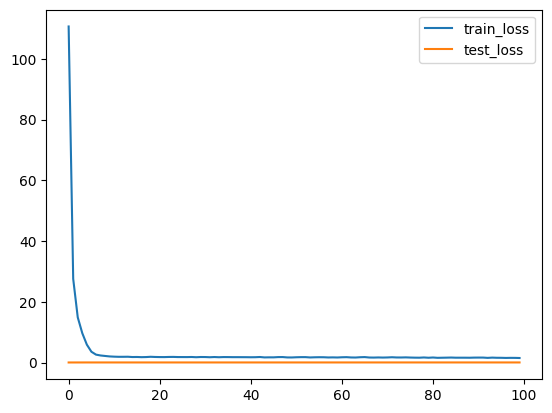

In [11]:

results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])